In [1]:
import sys

sys.path.append("../src/")

In [2]:
import numpy as np
import pandas as pd

import datetime
import logging
import os
import time
import torch

from torch import nn
from torch.nn import functional as F

from functools import cached_property

from torch.nn import Linear, ReLU, Sequential

from sklearn.metrics import average_precision_score, ndcg_score, roc_auc_score

In [3]:
import torch.optim as optim

In [4]:
from loss_functions import get_kld_loss, ZINORMLoss, coral, compute_covariance

In [5]:
sample_id = 1

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### Load data

In [7]:
cl_train_df = pd.read_csv(f"../data/diffusion_pretraining/cl_diffusion_train_sample{sample_id}.csv", index_col=0)
cl_train_df.shape

(1569, 7776)

In [8]:
cl_test_df = pd.read_csv(f"../data/diffusion_pretraining/cl_diffusion_test_sample{sample_id}.csv", index_col=0)
cl_test_df.shape

(175, 7776)

In [9]:
tcga_train_df = pd.read_csv(f"../data/diffusion_pretraining/tcga_diffusion_train_sample{sample_id}.csv", index_col=0)
tcga_train_df.shape

(476, 7776)

In [10]:
tcga_test_df = pd.read_csv(f"../data/diffusion_pretraining/tcga_diffusion_test_sample{sample_id}.csv", index_col=0)
tcga_test_df.shape

(120, 7776)

In [11]:
model1_in = torch.tensor(cl_train_df.values).to(device, torch.float32)
model2_in = torch.tensor(tcga_train_df.values).to(device, torch.float32)

### Pretrain VAEs

In [12]:
input_dim_vae = 7776
k_list = [128, 16]
actf_list = ["tanh", "tanh"]
is_real = True
eps = 1e-8
ridge_lambda = 0.05
is_mean = True
weight_decay = 1e-6

# The below modules are expected to be available in the scope where this module is instialized
from ffnzinb_model import ffnzinb
from vae_model import vae

ffb_zinb_model1 = ffnzinb(input_dim_vae).cuda(device)
vae_model1 = vae(input_dim_vae, k_list, actf_list, is_real).cuda(device)

ffb_zinb_model2 = ffnzinb(input_dim_vae).cuda(device)
vae_model2 = vae(input_dim_vae, k_list, actf_list, is_real).cuda(device)


#
zinb_layers_mu: 
OrderedDict([('mu', Linear(in_features=7776, out_features=7776, bias=True))])
#
zinb_layers_theta: 
OrderedDict([('theta', Linear(in_features=7776, out_features=7776, bias=True))])
#
zinb_layers_pi: 
OrderedDict([('pi', Linear(in_features=7776, out_features=7776, bias=True)), ('pi-actf', Sigmoid())])
#
U: encoder 
Sequential(
  (enc-0): Linear(in_features=7776, out_features=128, bias=True)
  (act-0): Tanh()
  (enc-1): Linear(in_features=128, out_features=16, bias=True)
  (act-1): Tanh()
)
#
mu_layer: 
Linear(in_features=16, out_features=8, bias=True)
#
sigma_layer: 
Linear(in_features=16, out_features=8, bias=True)
#
U: decoder 
Sequential(
  (-dec-0): Linear(in_features=8, out_features=16, bias=True)
  (-act-0): Tanh()
  (dec-0): Linear(in_features=16, out_features=128, bias=True)
  (act-0): Tanh()
  (dec-1): Linear(in_features=128, out_features=7776, bias=True)
  (act-1): Tanh()
)
#
zinb_layers_mu: 
OrderedDict([('mu', Linear(in_features=7776, out_features=7776, bi

In [13]:
num_iterations = 200
learning_rate = 1e-8
convg_thres = 1e-3


criterion = nn.MSELoss(reduction="mean")

params_list = []
params_list += list(vae_model1.parameters())
params_list += list(ffb_zinb_model1.parameters())
params_list += list(vae_model2.parameters())
params_list += list(ffb_zinb_model2.parameters())

optimizer = torch.optim.Adam(params_list, lr=learning_rate, weight_decay=0)


train_losses = []
val_errors = []
best_error = None
for epoch in range(num_iterations):
    optimizer.zero_grad()

    # ===================forward=====================
    x_enc1, X_train_mu1, logvar1, X_recons1 = vae_model1(model1_in)
    X_mu1, X_theta1, X_pi1 = ffb_zinb_model1(X_recons1)

    x_enc2, X_train_mu2, logvar2, X_recons2 = vae_model2(model2_in)
    X_mu2, X_theta2, X_pi2 = ffb_zinb_model2(X_recons2)

    coral_loss = coral(X_train_mu1, X_train_mu2)

    loss_zinb1 = ZINORMLoss(reduction="mean")(
        X_mu1,
        X_theta1,
        X_pi1,
        model1_in, 
        lamda=1e-3,
    )
    loss_vae1 = get_kld_loss(X_train_mu1, logvar1, is_mean=True)
    # print(loss_vae1)
    # print(loss_zinb1)

    loss_zinb2 = ZINORMLoss(reduction="mean")(
        X_mu2,
        X_theta2,
        X_pi2,
        model2_in, 
        lamda=1e-3,
    )
    loss_vae2 = get_kld_loss(X_train_mu2, logvar2, is_mean=True)

    loss_epoch = loss_zinb1 + loss_vae1 + coral_loss + loss_zinb2 + loss_vae2

    loss_epoch.backward()

    optimizer.step()
    train_losses.append(loss_epoch.item())

    print(
        "epoch [{}/{}], loss:{:.6f}".format(
            epoch + 1, num_iterations, loss_epoch.item()
        )
    )

    if (len(train_losses) > 2) and abs(
        train_losses[-1] - train_losses[-2]
    ) < convg_thres:
        print("Training converged, exiting")
        break

/home/ajayago/miniconda3/envs/tddpm/lib/python3.9/site-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


epoch [1/200], loss:8221220352.000000
epoch [2/200], loss:6578083328.000000
epoch [3/200], loss:8117216256.000000
epoch [4/200], loss:6292848128.000000
epoch [5/200], loss:9783664640.000000
epoch [6/200], loss:6078937600.000000
epoch [7/200], loss:7553168384.000000
epoch [8/200], loss:6409939968.000000
epoch [9/200], loss:7906435584.000000
epoch [10/200], loss:7380010496.000000
epoch [11/200], loss:6566591488.000000
epoch [12/200], loss:8024331776.000000
epoch [13/200], loss:5125745152.000000
epoch [14/200], loss:8551547904.000000
epoch [15/200], loss:9133894656.000000
epoch [16/200], loss:6556105728.000000
epoch [17/200], loss:6447825408.000000
epoch [18/200], loss:6672501760.000000
epoch [19/200], loss:7054342656.000000
epoch [20/200], loss:9110963200.000000
epoch [21/200], loss:8907618304.000000
epoch [22/200], loss:9051191296.000000
epoch [23/200], loss:7629004288.000000
epoch [24/200], loss:6552267776.000000
epoch [25/200], loss:6833601024.000000
epoch [26/200], loss:7106155520.00

<Axes: >

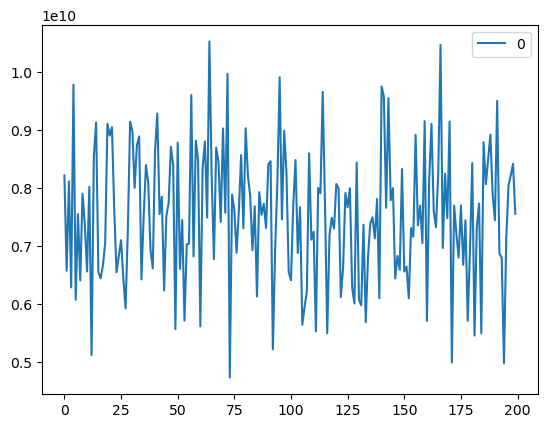

In [14]:
pd.DataFrame(train_losses).plot()

### DruID MTL

In [15]:
cl_responses_df = pd.read_csv("/data/ajayago/copied_from_cdal1/yiming_data_folder/dataset/CellLine/patient_auc.csv")
cl_responses_df

,depmap_id,drug_name,auc
0,ACH-000001,JW-7-24-1,0.778432
1,ACH-000002,JW-7-24-1,0.788327
2,ACH-000004,JW-7-24-1,0.737630
3,ACH-000006,JW-7-24-1,0.176396
4,ACH-000007,JW-7-24-1,0.569751
...,...,...,...
226791,ACH-001702,SL 0101-1,0.958591
226792,ACH-001703,SL 0101-1,0.497201
226793,ACH-001711,SL 0101-1,0.815928
226794,ACH-001715,SL 0101-1,0.981441


In [16]:
patient_responses_df = pd.read_csv("/data/ajayago/copied_from_cdal1/ajayago_home_folder/processed/TCGA_drug_response_010222.csv")
patient_responses_df

,patient.arr,drug.name,response,response_cat,drug
0,TCGA-G2-A2EC,Methotrexate,Partial Response,1,METHOTREXATE
1,TCGA-G2-A2EC,Doxorubicin,Partial Response,1,DOXORUBICIN
2,TCGA-G2-A2EC,Vinblastine,Partial Response,1,VINBLASTINE
3,TCGA-G2-A2EC,Cisplatin,Partial Response,1,CISPLATIN
4,TCGA-G2-A2EJ,Paclitaxel,Stable Disease,0,PACLITAXEL
...,...,...,...,...,...
1244,TCGA-BG-A0VZ,Cisplatin,Complete Response,1,CISPLATIN
1245,TCGA-BG-A0VZ,Paclitaxel,Complete Response,1,PACLITAXEL
1246,TCGA-BG-A0VZ,Doxorubicin,Complete Response,1,DOXORUBICIN
1247,TCGA-BG-A0VT,Carboplatin,Complete Response,1,CARBOPLATIN


In [17]:
train_tcga_with_response = patient_responses_df[patient_responses_df["patient.arr"].isin(tcga_train_df.index)].reset_index(drop=True)
train_tcga_with_response

,patient.arr,drug.name,response,response_cat,drug
0,TCGA-G2-A2EC,Methotrexate,Partial Response,1,METHOTREXATE
1,TCGA-G2-A2EC,Doxorubicin,Partial Response,1,DOXORUBICIN
2,TCGA-G2-A2EC,Vinblastine,Partial Response,1,VINBLASTINE
3,TCGA-G2-A2EC,Cisplatin,Partial Response,1,CISPLATIN
4,TCGA-G2-A2EJ,Paclitaxel,Stable Disease,0,PACLITAXEL
...,...,...,...,...,...
997,TCGA-QS-A8F1,Paclitaxel,Clinical Progressive Disease,0,PACLITAXEL
998,TCGA-2E-A9G8,Paclitaxel,Complete Response,1,PACLITAXEL
999,TCGA-2E-A9G8,Carboplatin,Complete Response,1,CARBOPLATIN
1000,TCGA-BG-A0VT,Carboplatin,Complete Response,1,CARBOPLATIN


In [18]:
test_tcga_with_response = patient_responses_df[patient_responses_df["patient.arr"].isin(tcga_test_df.index)].reset_index(drop=True)
test_tcga_with_response

,patient.arr,drug.name,response,response_cat,drug
0,TCGA-G2-A2EK,Methotrexate,Stable Disease,0,METHOTREXATE
1,TCGA-G2-A2EK,Doxorubicin,Stable Disease,0,DOXORUBICIN
2,TCGA-G2-A2EK,Vinblastine,Stable Disease,0,VINBLASTINE
3,TCGA-G2-A2EK,Cisplatin,Stable Disease,0,CISPLATIN
4,TCGA-DK-A3IQ,Gemcitabine,Stable Disease,0,GEMCITABINE
...,...,...,...,...,...
242,TCGA-QS-A5YQ,Carboplatin,Complete Response,1,CARBOPLATIN
243,TCGA-QS-A5YQ,Paclitaxel,Complete Response,1,PACLITAXEL
244,TCGA-BG-A0VZ,Cisplatin,Complete Response,1,CISPLATIN
245,TCGA-BG-A0VZ,Paclitaxel,Complete Response,1,PACLITAXEL


In [19]:
drug_fp = pd.read_csv("/data/ajayago/copied_from_cdal1/ajayago_home_folder/processed/drug_morgan_fingerprints.csv", index_col = 0)
drug_fp

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
drug_name,,,,,,,,,,,,,,,,,,,,,
JW-7-24-1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
KIN001-260,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NSC-87877,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
GNE-317,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NAVITOCLAX,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LGH447,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TRASTUZUMAB,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
WNT974,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score

In [21]:
# Held out TCGA dataset
test_features = []
test_y = []
drugs = []
for idx, row in test_tcga_with_response.iterrows():
    if row["drug"] in drug_fp.index:
        row_inp = []
        row_inp.extend(tcga_test_df.loc[row["patient.arr"]].values)
        row_inp.extend(drug_fp.loc[row["drug"]].values)
        test_y.append(row["response_cat"])
        test_features.append(row_inp)
        drugs.append(row["drug"])

In [22]:
test_features_tensor = torch.tensor(test_features)
test_y_tensor = torch.tensor(test_y)
print(test_features_tensor.shape, test_y_tensor.shape)

torch.Size([203, 9824]) torch.Size([203])


In [23]:
# CL train
cl_train_features = []
cl_train_y = []
for idx, row in cl_responses_df.iterrows():
    if (row["drug_name"] in drug_fp.index) and (row["depmap_id"] in cl_train_df.index):
        row_inp = []
        row_inp.extend(cl_train_df.loc[row["depmap_id"]].values)
        row_inp.extend(drug_fp.loc[row["drug_name"]].values)
        cl_train_y.append(row["auc"])
        cl_train_features.append(row_inp)

In [24]:
# TCGA train
tcga_train_features = []
tcga_train_y = []
for idx, row in train_tcga_with_response.iterrows():
    if row["drug"] in drug_fp.index:
        row_inp = []
        row_inp.extend(tcga_train_df.loc[row["patient.arr"]].values)
        row_inp.extend(drug_fp.loc[row["drug"]].values)
        tcga_train_y.append(row["response_cat"])
        tcga_train_features.append(row_inp)

In [25]:
class DrugTRS_AUDRC_RECIST(nn.Module):
    '''
    Used for training 2 tasks - cell line-drug AUDRC prediction(regression) and patient-drug RECIST prediction(classification)
    300 dimensional input for drugs
    '''
    def __init__(self,single=False):
        super(DrugTRS_AUDRC_RECIST, self).__init__()
        self.drug_embedder = self.fnn(2048, 64, 16, 8)
        self.cell_line_embedder = vae_model1

        self.patient_embedder = vae_model2
        self.recist_predictor = nn.Sequential(self.fnn(16, 64, 16, 1), ) # takes as input concatenated representation of cell line/patient and drug
        self.audrc_predictor = nn.Sequential(self.fnn(16, 64, 16, 1), )#nn.Sigmoid())

        self.AUDRC_specific = nn.ModuleDict({'embedder': self.cell_line_embedder,
                                              'predictor': self.audrc_predictor})
        self.RECIST_specific = nn.ModuleDict({'embedder': self.patient_embedder,
                                                'predictor': self.recist_predictor})

        self.name = 'DrugTRS - train AUDRC and RECIST together '
        drug_names = ["DOXORUBICIN", "CISPLATIN", "PACLITAXEL", "GEMCITABINE", "5-FLUOROURACIL", "DOCETAXEL", "CYCLOPHOSPHAMIDE"]
        uniq_drug_names = np.unique(np.array(drug_names))
        self.device = torch.device(f'cuda:{args.device}' if torch.cuda.is_available() else 'cpu')
        
    def fnn(self, In, hidden1, hidden2, out):
        return nn.Sequential(nn.Linear(In, hidden1), nn.ReLU(), #nn.BatchNorm1d(hidden1),
                             nn.Linear(hidden1, hidden2), nn.ReLU(), #nn.BatchNorm1d(hidden2),
                             nn.Linear(hidden2, out))

    def forward(self,x1,x2): # x1 is Rad51, x2 is cell lines - each row is of the form [mutation 324, drug fp]
        # input is of dim (batch_size, 325)
        # drug input
        patient_drug_input = x1[:, 7776:].to(self.device, torch.float32)
        cl_drug_input = x2[:, 7776:].to(self.device, torch.float32)
    
        # mutation profile
        patient_mut_input = torch.Tensor(x1[:,:7776]).to(self.device, torch.float32)
        cl_mut_input = torch.Tensor(x2[:,:7776]).to(self.device, torch.float32)
        
        # drug embedding
        patient_drug_emb = self.drug_embedder(patient_drug_input)
        cl_drug_emb = self.drug_embedder(cl_drug_input)
        
        # mutation embedding
        patient_mut_emb = self.patient_embedder(patient_mut_input)[0]
        cl_mut_emb = self.cell_line_embedder(cl_mut_input)[0]
        
        # concat and pass through prediction heads
        patient_drug_cat_emb = torch.cat((patient_mut_emb, patient_drug_emb), dim=1)
        cl_drug_cat_emb = torch.cat((cl_mut_emb, cl_drug_emb), dim=1)
        
        recist_prediction = self.recist_predictor(patient_drug_cat_emb)
        audrc_prediction = self.audrc_predictor(cl_drug_cat_emb)
        
        return recist_prediction, audrc_prediction

In [26]:
from dotmap import DotMap
args = DotMap()
args.model='DrugTRS_AUDRC_RECIST'
args.batch_size=256
args.epochs=100
args.moo='CS'
args.inv_preference=[0.1, 1]
args.seed=0
args.device=0
args.valid_interval=100

In [27]:
seed = args.seed
lr_main_optim = 1e-5
lr_cl_optim = 1e-6
lr_patient_optim = 1e-4
lr_drug_optim = 1e-4
args.lr_main_optim = lr_main_optim
args.lr_cl_optim = lr_cl_optim
args.lr_patient_optim = lr_patient_optim
args.lr_drug_optim = lr_drug_optim

In [28]:
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

tasks = ['RECIST_prediction', 'AUDRC_prediction']  # prediction tasks; model consumes in this order; important

# model
model = eval(f'{args.model}()')
device = torch.device(f'cuda:{args.device}' if torch.cuda.is_available() else 'cpu')
print(f'Using {device} device...')
model = model.to(device)
specific_submodels = {
                      'RECIST_prediction': model.RECIST_specific,
                      'AUDRC_prediction': model.AUDRC_specific
                     }
common_submodel = model.drug_embedder

# optimization related
batch_size = args.batch_size

optimizer_main = optim.Adam(list(model.audrc_predictor.parameters())+
                            list(model.recist_predictor.parameters())
                            , lr=lr_main_optim) 
optimizer_drug = optim.Adam(model.drug_embedder.parameters(), lr = lr_drug_optim)
optimizer_cl = optim.Adam(model.cell_line_embedder.parameters(), lr=lr_cl_optim)
optimizer_patient = optim.Adam(model.patient_embedder.parameters(), lr=lr_patient_optim)
criteria = {
            'RECIST_prediction': nn.BCEWithLogitsLoss(),
            'AUDRC_prediction': nn.MSELoss(),
           }

Using cuda:0 device...


In [29]:
from torch.utils.data import DataLoader, Dataset

In [30]:
class CustomDataset(Dataset):
    def __init__(self, train_features, train_y):
        self.train_features = train_features
        self.train_y = train_y

    def __len__(self):
        return len(self.train_features)

    def __getitem__(self, idx):
        return torch.Tensor(self.train_features[idx]), self.train_y[idx]

In [31]:
cl_training_data = CustomDataset(cl_train_features,cl_train_y)
cl_train_dataloader = DataLoader(cl_training_data, batch_size=batch_size, shuffle=True)

In [32]:
tcga_training_data = CustomDataset(tcga_train_features, tcga_train_y)
tcga_train_dataloader = DataLoader(tcga_training_data, batch_size=batch_size, shuffle=True)

In [33]:
tcga_test_data = CustomDataset(test_features, test_y)
tcga_test_dataloader = DataLoader(tcga_test_data, batch_size=batch_size, shuffle=False)

In [34]:
train_loaders = {
    "RECIST_prediction": tcga_train_dataloader,
    "AUDRC_prediction": cl_train_dataloader
}

In [35]:
datasets = {
                'RECIST_prediction': ['tcga'],
                'AUDRC_prediction': ['ccle'],
}

In [36]:
# maximum number of iterations considering all datasets
min_iterations = {task: [len(loader) * args.epochs for loader in loaders]
                  for task, loaders in train_loaders.items()}
max_iterations = max([max(iters) for iters in min_iterations.values()])


print(f'# of iterations to run = {max_iterations}')
inv_preference = np.array(args.inv_preference)
preference = 1.0 / inv_preference
preference /= preference.sum()
intra_preference = {task: np.ones(len(datasets[task])) / len(datasets[task]) for task in tasks}
if args.moo == 'EPO':
    epo_ = EPO(3, inv_preference)
    epo_dt = EPO(3, np.array([1.,1.,1.]), eps=0.3)
    epo_dr = EPO(2, np.array([1., 1.]))
    epo_ds = EPO(2, np.array([1., 1.]))
    epos = {task: ep for task, ep in zip(tasks, [epo_dt, epo_dr, epo_ds])}

epochs_completed = {task: {ds: 0 for ds in task_datasets}
                    for task, task_datasets in datasets.items()}
train_iter_loaders = {task: [iter(loader) for loader in loaders]
                      for task, loaders in train_loaders.items()}

# of iterations to run = 200


In [37]:
# Training
for i in range(max_iterations):
    all_inputs = {task: [] for task in train_loaders}
    all_targets = {task: [] for task in train_loaders}
    for task, iter_loaders in train_loaders.items():
        for inp, y in iter_loaders:
            all_inputs[task].append(inp)
            all_targets[task].append(y)
    all_outputs = model(torch.cat(all_inputs["RECIST_prediction"]), torch.cat(all_inputs["AUDRC_prediction"]))
    all_losses = {task: [criteria[task](all_outputs[tid], torch.cat(all_targets[task]).unsqueeze(1).to(device, torch.float32))
                         ]
                  for tid, (task, task_targets) in enumerate(all_targets.items())}
    model.zero_grad()
    optimizer_main.zero_grad()
    optimizer_cl.zero_grad()
    optimizer_patient.zero_grad()
    optimizer_drug.zero_grad()
    intra_coefs = {task: {ds: 0 for ds in datasets[task]} for task in tasks}
    inter_coefs = {task: 0 for task in tasks}
    if args.moo in ['LS', 'CS', 'ST']:
        all_rel_losses = {task: [ds_loss * intra_preference[task][did] * preference[tid]
                                 for did, ds_loss in enumerate(task_losses)]
                          for tid, (task, task_losses) in enumerate(all_losses.items())}
#         print(all_rel_losses)
        if args.moo == 'LS':
            total_loss = sum([sum(task_rel_losses)
                              for task_rel_losses in all_rel_losses.values()])

            for tid, task in enumerate(tasks):
                inter_coefs[task] = preference[tid]
                for did, ds in enumerate(datasets[task]):
                    intra_coefs[task][ds] = intra_preference[task][did]
        elif args.moo == 'CS':
            total_loss = max([max(task_rel_losses)
                              for task_rel_losses in all_rel_losses.values()])
#             total_loss = max(all_rel_losses["RECIST_prediction"]) # for single task
            print(total_loss)
            max_tid, max_rel_loss = None, -1
            for tid, (task, task_rel_losses) in enumerate(all_rel_losses.items()):
                max_did = max(range(len(task_rel_losses)), key=lambda lid: task_rel_losses[lid])
                intra_coefs[task][datasets[task][max_did]] = intra_preference[task][max_did]
                if task_rel_losses[max_did] > max_rel_loss:
                    max_rel_loss = task_rel_losses[max_did]
                    max_tid = tid
            inter_coefs[tasks[max_tid]] = preference[max_tid]
        else:
            st_id = np.argmax(preference)
            total_loss = sum(all_rel_losses[tasks[st_id]]) / preference[st_id]

            inter_coefs[tasks[st_id]] = 1
            for task in tasks:
                for did, ds in enumerate(datasets[task]):
                    intra_coefs[task][ds] = intra_preference[task][did]
        total_loss.backward()
    elif args.moo == 'EPO':
        n_tasks = len(tasks)
        shared_grads = [[] for _ in range(n_tasks)]  # NOTE: DO NOT USE [[]] * n_tasks.
        apparent_losses = np.zeros(n_tasks)
        for tid, (task, task_losses) in enumerate(all_losses.items()):
            n_ds = len(task_losses)  # number of datasets in the task
            specific_submodel = specific_submodels[task]
            specific_submodel_grads = [[] for _ in range(n_ds)]
            common_submodel_grads = [[] for _ in range(n_ds)]
            for did, ds_loss in enumerate(task_losses):
                ds_loss.backward()
                for param in specific_submodel.parameters():
                    specific_submodel_grads[did].append(param.grad.clone())
                for param in common_submodel.parameters():
                    common_submodel_grads[did].append(param.grad.clone())
                specific_submodel.zero_grad()
                common_submodel.zero_grad()
            GG = torch.zeros(n_ds, n_ds)
            for grads in [specific_submodel_grads, common_submodel_grads]:
                for j in range(n_ds):
                    for k in range(j, n_ds):
                        Gj_dot_Gk = sum([gj.flatten().dot(gk.flatten())
                                         for gj, gk in zip(grads[j], grads[k])]).cpu()
                        GG[j, k] += Gj_dot_Gk
                        GG[k, j] += Gj_dot_Gk

            l = np.array([ds_loss.item() for ds_loss in task_losses], dtype=np.double)
            print('intra-task epo:', task)
            beta = epos[task].get_beta(l, GG.numpy().astype(np.double))
            for pid, param in enumerate(specific_submodel.parameters()):
                param.grad = sum([beta[j] * specific_submodel_grads[j][pid]
                                  for j in range(n_ds)])

            for pid, _ in enumerate(common_submodel.parameters()):
                shared_grads[tid].append(sum([beta[j] * common_submodel_grads[j][pid]
                                              for j in range(n_ds)]))
            apparent_losses[tid] = l.dot(beta)

            for did, ds in enumerate(datasets[task]):
                intra_coefs[task][ds] = beta[did]

        GG = torch.zeros(n_tasks, n_tasks)
        for j in range(n_tasks):
            for k in range(j, n_tasks):
                GG[j, k] = sum([gj.flatten().dot(gk.flatten())
                                for gj, gk in zip(shared_grads[j], shared_grads[k])])
                GG[k, j] = GG[j, k]
        print('inter-task epo')
        beta = epo_.get_beta(apparent_losses, GG.numpy().astype(np.double))
        for pid, param in enumerate(common_submodel.parameters()):
            param.grad = sum([beta[j] * shared_grads[j][pid]
                              for j in range(n_tasks)])

        for tid, task in enumerate(tasks):
            for param in specific_submodels[task].parameters():
                param.grad *= beta[tid]

        for tid, task in enumerate(tasks):
            inter_coefs[task] = beta[tid]
    else:
        raise NotImplementedError('Choose an moo method')

    optimizer_main.step()
    if i > 10:
        optimizer_cl.step()
        optimizer_patient.step()
        optimizer_drug.step()
    log_losses = {task: {ds: loss.item() for ds, loss in zip(datasets[task], all_losses[task])}
                  for task in tasks}

tensor(0.6374, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6381, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6378, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6356, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6379, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6361, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6339, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6369, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6357, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6356, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6366, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6366, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6344, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6360, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6358, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6373, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6346, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6363, device='cuda:0', grad_fn=<MulBack

In [38]:
# Inference
test_loaders = {
    "RECIST_prediction": tcga_test_dataloader,
    "AUDRC_prediction": cl_train_dataloader
}
all_inputs = {task: [] for task in test_loaders}
all_targets = {task: [] for task in test_loaders}
for task, iter_loaders in test_loaders.items():
    for inp, y in iter_loaders:
        all_inputs[task].append(inp)
model.eval()
all_outputs = model(torch.cat(all_inputs["RECIST_prediction"]), torch.cat(all_inputs["AUDRC_prediction"]))
# print(all_outputs)
# We are interested in RECIST responses so only using the first part
results = []
for res in all_outputs[0]:
    results.append(res[0].cpu().detach().item())

y_pred_test = np.array(results).flatten()

In [39]:
auroc = roc_auc_score(test_y, y_pred_test)
auprc = average_precision_score(test_y, y_pred_test)
print(f"AUROC: {auroc}, AUPRC: {auprc}")

AUROC: 0.4167544783983141, AUPRC: 0.6016029626117769
